# TP: détermination des modes de variabilité interne et de leurs téléconnexions
## Un exemple avec l'Oscillation Atlantique Nord (NAO) et le climat européen

Saïd Qasmi (said.qasmi@meteo.fr)

Votre notebook, renommé suivant le format `notebook_VOTRE_NOM_DE_FAMILLE.ipynb` sont à déposer sur l'espace suivant : https://drive.google.com/drive/folders/11xArlL9_KPiczhXC_YBG1vphvuhVHzhH

### Rappels du cours sur la variabilité interne (cf. cours de Julien Cattiaux n°03/10 donné en première année)

La variabilité d'une grandeur physique (température, humidité des sols...) à une échelle de temps longue (à partir de l'intra-saisonnier jusqu'au multi-dénnal), résulte de l'intégration d’une multitude de processus couplés dans le temps et dans l’espace dont les origines précises et exhaustives sont impossibles à déterminer. Une hypothèse simplificatrice est de considérer que la variabilité de chaque composante du système climatique (océan, atmosphère, cryosphère etc.) peut être décomposée en entités qui sont récurrentes temporellement et spatialement. Ces entités, appelées modes de variabilité, permettent de réduire les degrés de liberté du système climatique, et constituent autant de briques élémentaires pour comprendre des phénomènes complexes. Ces modes de variabilité sont pilotés par des mécanismes intrinsèques à la variabilité interne (et peuvent également l'être par les forçages externes).

L'Oscillation Atlantique Nord est un mode de variabilité parmi d'autres. Les atmosphériciens l'appellent souvent **"régime de temps"**. Souvent, 4 régimes de temps sont utilisés pour caractériser la circulation atmosphérique sur l'Atlantique Nord : la NAO et sa déclinaison en deux phases **NAO+** et **NAO-**, la dorsale Atlantique (Atlantic Ridge, **AR**) et le blocage (Blocking, **BL**).

A ses modes de variabilité, peuvent être associés des **téléconnexions** atmosphériques. Celles-ci définissent les relations physiques qu'entretiennent les modes de variabilité avec le climat *in situ* ou à plus grande distance via des mécanismes ondulatoires du type onde de Rossby.

Dans le cas de l'Atlantique Nord, la NAO caractérise non seulement la circulation atmosphérique sur ce bassin océanique, mais conditionne également le climat des terres adjacentes, notamment l'Eurasie, l'Est américain, le Groënland...

### Objectifs du TP :
- Comprendre les caractéristiques d'un mode de variabilité, en explorant sa structure spatio-temporelle et les nombreuses techniques pour le construire (deux seront employées ici)
- Utiliser l'Analyse en Composantes Principales (ACP) et comprendre son intérêt pour l'étude du climat
- Faire des progrès avec python et la libraire xarray, utile pour traiter des données météo/climat.

### Données à disposition :
3 variables climatiques hivernales (moyennées sur les mois Décembre-Janvier-Février) sur le domaine `[-80°,40°E]x[30°,70°N]` au cours de la période 1949-2016 :
- `SLP` (Sea Level Pressure) : pression au niveau de la mer
- `P` : Cumul de précipitations
- `T` : Température à 2 mètres.

Les 3 champs correspondent aux fichiers netcdf (avec l'extension `.nc`) situés dans le dossier `data/`.

### Prise en main et aperçu des données :

Chaque variable est un tableau de dimension 3 : `[time x latitude x longitude]`

`ncview` est une application très pratique de visualisation de fichiers netcdf. Pour avoir une idée de ce que contient par exemple le fichier `T_DJF.nc`, il suffit de se placer dans le répertoire `data/` et de lancer la commande suivante dans un terminal :

`ncview T_DJF.nc`

Une fenêtre s'affiche et contient les différentes variables et ses attributs. En cliquant sur le bouton `tas`, on obtient la projection de cette variable sur une carte pour une année donnée. Vous pouvez jouer avec le défilement des années, ou encore cliquer sur un point de la carte pour obtenir la série chronologique associée au point.

### Chargement/installation des librairies python

La cellule suivante contient les librairies à charger, elle n'est pas à modifier.

***Si l'execution de la cellule ne fonctionne pas:***
- Installer les packages manquant en tapant dans un terminal, sans être connecté au VPN Météo-France :

`pip3 install --user le_package_en_question`

- Redémarrer le noyau dans le menu ci-dessus.

In [1]:
import os
import numpy as np
import xarray as xr
from eofs.xarray import Eof
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

### Chargement des variables, et prise en main de xarray

Dans un premier temps, il s'agit de charger les champs `T`, `SLP` et `P` avec la fonction `open_dataset` de `xarray`.

In [2]:
# Set the path where data are located
path_data = "./data/"

# tas, psl and pr stand for the variable names within each netcdf file
T = xr.open_dataset(path_data+"T_DJF.nc").tas
SLP = xr.open_dataset(path_data+"SLP_DJF.nc").psl
P = xr.open_dataset(path_data+"P_DJF.nc").pr

Puis on vérifie que les variables chargés ont bien les bonnes coordonnées et dimensions.

In [5]:
# Verify fields dimensions
print(SLP.sizes)
print(SLP.coords)

Frozen({'time': 68, 'lat': 41, 'lon': 121})
Coordinates:
  * lon      (lon) float32 -80.0 -79.0 -78.0 -77.0 -76.0 ... 37.0 38.0 39.0 40.0
  * lat      (lat) float32 30.0 31.0 32.0 33.0 34.0 ... 66.0 67.0 68.0 69.0 70.0
  * time     (time) datetime64[ns] 1949-01-01 1950-01-01 ... 2016-01-01


On peut maintenant commencer à construire nos modes de variabilité !

### Plusieurs définitions de la NAO

### Méthode empirique

Assez tôt dans l'histoire, les observateurs du ciel (ou plutôt de baromètres) ont remarqué que des changements de pression récurrents avaient lieu sur deux zones préférentielles où des stations de mesure étaient présentes:
- un anticyclone subtropical situé au-dessus des îles des Açores dans le centre de l'Atlantique Nord 
- un système dépressionnaire centré sur l'Islande

Les observations de pression sur ces régions (dès les années 1770 !) font état d'une "oscillation" du gradient de pression entre ces deux zones et d'un va-et-vient entre deux modes dominants :
- un "mode positif", pour lequel l'anticyclone des Açores et la dépression d'Islande sont renforcés 
- un "mode négatif", dans lequel des anomalies anticycloniques sont obtenues sur la région islandaise et des anomalies cycloniques sont obtenues sur les Açores

Avant même de parler de "modes de variabilité", l'appellation de NAO a été choisie pour qualifier des oscillations, et a fortiori ses deux modes NAO+ et NAO-.

Dans un premier temps, nous allons reconstruire la NAO à partir de cette simple définition empirique.

In [6]:
# NAO from ground measurement stations
# Extract Reykjavik and Azores time series
SLP_Rey = SLP.sel(lat=64,lon=-22)
SLP_Azo = SLP.sel(lat=38,lon=-26)

# Compute the gradient between the two area
index_nao1_brut = SLP_Azo - SLP_Rey

# Standardize the index
index_nao1 = (index_nao1_brut - np.mean(index_nao1_brut)) / np.std(index_nao1_brut)

On peut d'abord s'assurer que les intuitions et les observations de nos prédécesseurs étaient visiblement correctes :

Text(0.5,1,'Reykjavic vs Azores SLP')

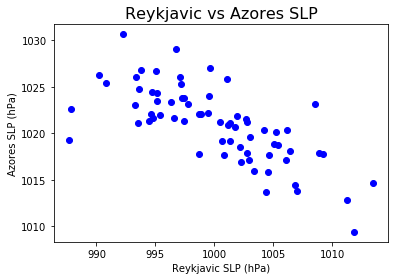

In [7]:
# Plot
plt.plot(SLP_Rey,SLP_Azo,'bo')
plt.xlabel('Reykjavic SLP (hPa)') 
plt.ylabel('Azores SLP (hPa)')
plt.title('Reykjavic vs Azores SLP', fontsize=16)

Voici à quoi ressemble la série temporelle de la NAO avec cette définition basée sur la mesure.

Text(0.5,1,'Empirical NAO index')

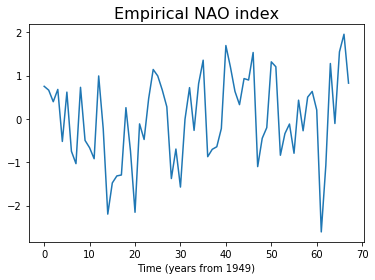

In [8]:
plt.plot(index_nao1)
plt.xlabel('Time (years from 1949)') 
plt.ylabel('')
plt.title('Empirical NAO index', fontsize=16)

Les "oscillations" sont ici matérialisées par des périodes pendant lesquelles l'indice devient positif (par exemple entre les années 22 et 27) puis négatif (entre les années 28 et 32). On peut maintenant déterminer la structure spatiale de la NAO, en calculant la corrélation temporelle entre la série chronologique de la NAO que l'on vient de calculer et le champ de pression `SLP`.

In [9]:
# Calculate correlations between the NAO index and SLP time-series at each grid-point.
lon = SLP.lon
lat = SLP.lat
# Make use of the already well conditionned array of SLP to build an array for the correlation
Corr = SLP.sel(time='1950-01-01')
Corr.attrs["long_name"] = "NAO/SLP correlation"
Corr.attrs["units"] = ""
Corr.attrs["var_desc"] = ""
Corr.attrs["level_desc"] = ""

for i in lat:
    for j in lon:
        corel = np.corrcoef(index_nao1,SLP.sel(lat=i,lon=j))
        Corr.loc[dict(lat=i,lon=j)] = corel[0,1]


Text(0.5,1,'Empirical NAO')

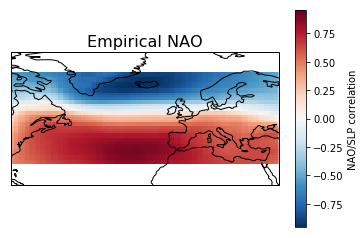

In [10]:
# Plot NAO map
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([min(lon), max(lon), min(lat)-10, max(lat)])
ax.coastlines() 
Corr.plot()
ax.set_title('Empirical NAO', fontsize=16)


On voit bien que la corrélation permet de caractériser spatialement l'indice de NAO, avec les maximums des centres d'action en Islande et sur les Açores.

Cette (très) simple caractérisation de la NAO est encore largement utilisé aujourd'hui en météorologie appliquée à la prévision saisonnière, et même en recherche lorsque l'on évalue la qualité d'un modèle de climat par rapport aux observations.

### Méthodes numériques

Comme énoncé au début de ce TP, **les modes de variabilité constituent une grille de lecture simplificatrice de la variabilité climatique au sens large**. L'étude des interactions entre différents modes permet alors de rendre accessible la compréhension de la dynamique physique d'un modèle de climat.

Or, un modèle reste modèle, et celui-ci reste entaché d'erreurs lorsqu'il est comparé aux observations. Si on prend le cas de la NAO, il n'est pas rare qu'un modèle simule mal (voire ne simule pas du tout) la dépression d'Islande et/ou l'anticyclone des Açores. Un exemple classique est une mauvaise position des centres d'actions qui peuvent être spatialement décalés l'un par rapport à l'autre. Une représentation spatiale biaisée de la NAO dans un modèle ne signifie pas pour autant qu'il est bon pour la poubelle. On peut très bien avoir une très bonne représentation spatiale et une mauvaise représentation de l'amplitude des anomalies, et donc un faible gradient...

En conséquence, une estimation robuste de la NAO simulée par un modèle peut s'avérer problématique si on se base uniquement sur la méthode empirique que l'on a appliqué aux observations.

L'essor de la modélisation numérique de l'atmopshère puis du climat a permis de largement s'affranchir des méthodes empiriques pour caractériser la NAO et les modes de variabilité en général.

### L'Analyse en Composantes Principales (ACP)

Le but des modes de variabilité est de simplifier un objet de trop grande dimension, à savoir le climat et ses (extrêmement) nombreux degrés de liberté, pour être compris par un cerveau humain. Nous devons donc réduire la dimension de cet objet, pour obtenir un nouvel objet de taille beaucoup plus modeste (de l'ordre de 10). L'Analyse en Composantes Principales (ACP) est un formidable outil mathématique pour y parvenir.

#### Rappel sur la définition d'une ACP

On considère un champ $X$ (température, pression...) dépendante de l'espace $s$ (en latitude et longitude) et du temps $t$. La dimension temporelle $N_t$ est par exemple le nombre d'années d'observations de ce champ. La dimension spatiale $N_s$ est le nombre de points géographiques (par exemple le nombre de longitudes multiplié par le nombre de latitudes).

La question est la suivante : **quels sont les principaux modes de variabilité spatio-temporelle de $X(s,t)$?**

L'ACP consiste simplement à redéfinir $X$, en séparant l'espace $s$ et le temps $t$ par décomposition en $K$ valeurs propres de la matrice de covariance de $X$ (notée $C$, symétrique et semi-définie positive) :

$$X(s,t) = \sum_{k=1}^{K} \color{green}{p_k(t)}.\color{red}{e_k(s)}$$

<span style="color:green">
Composantes Principales (PCs)<br/>
- coefficients temporels pour recombiner les $e_k(s)$<br/>
- variances = valeurs propres de $C$<br/>
- non-corrélées, $cor(p_k,p_{k'}) = \delta_{kk'}$<br/>
</span>
<br/>
<span style="color:red">
Fonctions Orthogonales Empiriques (EOFs)<br/>
- vecteurs spatiaux (cartes) à partir desquels les données sont combinées<br/>
- vecteurs propres de $C$<br/>
- orthonormales, $<e^t_k|e_{k'}> = \delta_{kk'}$
</span>

Voici comment sont déterminés mathématiquement les vecteurs et valeurs propres de $C$:
1. On cherche $e_1$ unitaire qui maximise la variance de $X$ expliquée par $e$ :
$$ \mathrm{max}[V_{e_k}(X) = e^tX^tXe = e^tCe ] \quad \textrm{avec} \quad e^te = 1$$
2. Si on note $\lambda_1 > \lambda_2 > ... > \lambda_K$ les valeurs propres de $C$ , on montre que $e_1$ est le vecteur propre de $C$ associé à $\lambda_1$ :
$$Ce_1 = \lambda_1e_1$$
3. On cherche $e_2$ de façon similaire avec comme contraintes $e^te = 1$ et $e^te_1 = 0$
4. On montre que $e_2$ est le vecteur propre de $C$ associé à $\lambda_2$, et ainsi de suite
5. On en déduit les PCs par projections orthogonales :
$$ \forall k \quad p_k = X e_k $$

Un mode de variabilité $k$ va donc être caractérisé par une composante principale $p_k$ (une série temporelle) à laquelle est associée une EOF $e_k$ (une carte).

### Détermination des modes de variabilité atmosphériques via l'ACP

Appliquer la méthode de l'ACP à la pression `SLP` nous donnera donc les directions privilégiés que prennent les variations de celle-ci dans l'espace des phases... Coder l'algorithme de maximisation de la variance serait parfait pour vraiment comprendre cette technique, mais un TP de 2 heures est loin d'être suffisant... La librairie python `eof` qui prend en entrée des tableaux formatés par `xarray` se chargera de faire le calcul pour nous.

Les fonction `eofsAsCovariance` et `pcs` de cette librairie appliquées au champ `SLP` vont nous permettre de déterminer ses modes de variabilité.

Dans un premier temps, nous allons décomposer ce champ en 3 modes de variabilités.

In [11]:
# Create a solver class, this is required to compute the EOFs and PCs
solver = Eof(SLP)

# Number of modes
n=3

# Retrieve the associated EOFs/PCs from the solver class
eofs = solver.eofsAsCovariance(neofs=n)
pcs = solver.pcs(pcscaling=1, npcs=n)

Vous pouvez constater les dimensions des objets obtenus, cohérentes avec la décomposition donnée ci-dessus.

In [13]:
print("EOFs")
print(eofs.coords)
print("-------------")
print("PCs")
print(pcs.coords)

EOFs
Coordinates:
  * mode     (mode) int64 0 1 2
  * lat      (lat) float32 30.0 31.0 32.0 33.0 34.0 ... 66.0 67.0 68.0 69.0 70.0
  * lon      (lon) float32 -80.0 -79.0 -78.0 -77.0 -76.0 ... 37.0 38.0 39.0 40.0
-------------
PCs
Coordinates:
  * time     (time) datetime64[ns] 1949-01-01 1950-01-01 ... 2016-01-01
  * mode     (mode) int64 0 1 2


### Question :
Vérifier que les 3 premières composantes principales sont orthogonales deux à deux dans la cellule ci-dessous.

In [12]:
# Votre réponse ici

#

Regardons maintenant à quoi ressemblent les 4 premiers modes de variabilité...

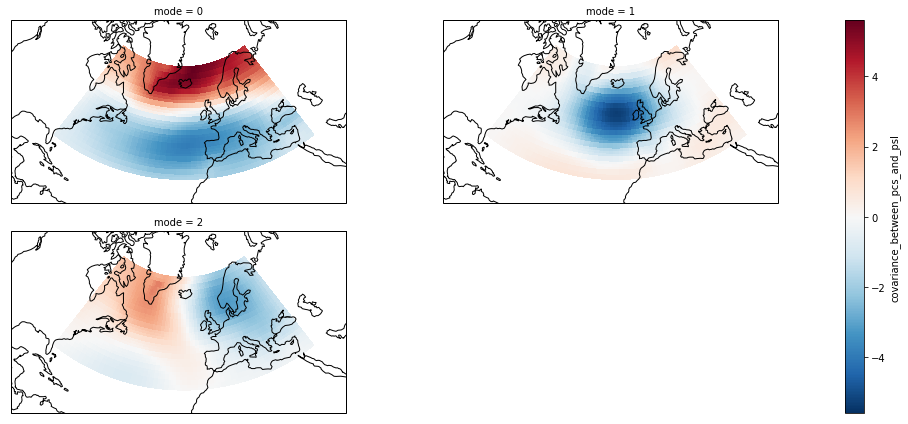

In [13]:
# This is the map projection we want to plot *onto*
map_proj = ccrs.LambertConformal(central_longitude=-20, central_latitude=45)
p = eofs.plot(transform=ccrs.PlateCarree(),  # the data's projection
             col='mode', col_wrap=2,  # multiplot settings
             aspect=len(lon) / len(lat),  # for a sensible figsize
             subplot_kws={'projection': map_proj})  # the plot's projection

# We have to set the map's options on all axes
for ax in p.axes.flat:
    ax.coastlines()
    ax.set_extent([-85, 40, 10, 75])

L'EOF du premier mode de variabilité ressemble beaucoup à la NAO n'est-ce pas (au signe près) ? Pour s'en convaincre, regardons l'allure de la PC correspondante et superposons la série chronologique à la NAO calculée de manière empirique.

Cor(NAO1/NAO2) = 0.9289647463944394


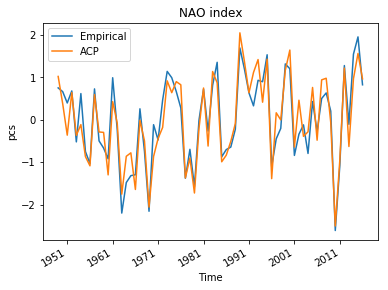

In [14]:
# Select the first PC
index_nao2 = pcs.sel(mode=0)*-1

# Plot
index_nao1.plot(label='Empirical')
index_nao2.plot(label='ACP')
plt.title("NAO index")
plt.legend()

# Confirm it by the correlation
corel = np.corrcoef(index_nao2,index_nao1)
print("Cor(NAO1/NAO2) = "+str(corel[0,1]))

Visiblement, les observateurs du XIXè siècle avaient raison d'identifier la NAO comme un mode de variabilité ! On retrouve presque exactement par l'ACP la même série temporelle que par le calcul empirique.

### Question :

Mais au fait, pourquoi le premier EOF est-il de signe inverse en utilisant cette méthode ? Est-ce que c'est grave ?


<span style="background:rgb(230,255,230)">
Votre réponse ici
</span>

### Les autres modes de variabilité et la notion de pourcentage de variance expliquée

C'est bien beau de retrouver mathématiquement la NAO calculée empiriquement avec l'ACP, mais on pourrait se demander à quoi elle sert si une simple différence entre deux stations de mesure permet de le faire ?

La réponse est : à rien du tout.

Mais on peut aller beaucoup plus loin dans l'interprétation des modes de variabilité calculés par l'ACP que par une simple estimation empirique. L'ACP classe par ordre décroissant les valeurs propres associés aux EOFs qui expliquent le maximum de variance du champ $X$ (par exemple la pression `SLP`). A chaque valeur propre $\lambda_k$ est associé un pourcentage de variance de $X$ expliquée par le vecteur propre $e_k$. En d'autres termes, il est possible avec l'ACP de quantifier à quel point la NAO, ainsi que les autres modes de variabilité, contribuent à expliquer la variabilité de la pression observée ces 70 dernières années.

L'attribut `VarianceFraction` de l'objet `solver` défini ci-dessus permet d'obtenir ces différents pourcentages.

In [15]:
# Get the explained variance for each mode
variance_fractions = solver.varianceFraction(neigs=n)
print(variance_fractions)
print("Pourcentage total : ")
print(sum(variance_fractions))

<xarray.DataArray 'variance_fractions' (mode: 3)>
array([0.45406285, 0.19205147, 0.13942564], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2
Attributes:
    long_name:  variance_fractions
Pourcentage total : 
<xarray.DataArray 'variance_fractions' ()>
array(0.78553995)
Coordinates:
    mode     int64 2


On remarque avec cette méthode que la NAO contribue à hauteur d'environ 45 % dans l'explication de la variabilité de la pression, et qu'il suffit de décomposer ce champ en seulement 3 modes pour expliquer quasiment 80 %.

### Question bonus

Comment s'appellent les deux autres modes de variabilité que l'on a déterminé avec l'ACP ? Leur signe est-il bien défini ?

<span style="background:rgb(230,255,230)">
Votre réponse ici
</span>

## Teleconnexions entre les modes de variabilité atmosphérique de l'Atlantique Nord et le climat européen

Comme énoncé dans l'introduction de ce TP, on associe à ces modes de variabilité des téléconnexions sur les continents adjacents. Dans le cas de la NAO, il est connu qu'à une situation de NAO+, sont associés un excès de précipitations sur la moitié Nord de l'Europe et un déficit sur la Méditerranée, et inversement en situation NAO-. Vous avez déjà calculé ces composites de température et précipitations en TP de première année. Nous retrouvons ici ce résultat avec la NAO que l'on vient de calculer avec l'ACP (mais ça marche aussi avec la NAO empirique).

Text(0.5,1,'Precipitation/NAO- composites')

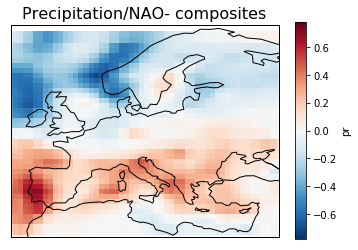

In [18]:
# Center each field to get the anomalies
Tano = T - T.mean(dim="time")
Pano = P - P.mean(dim="time")

# T and P anomalies during an NAO- phase
# Get the field values for years when the NAO index is negative
Tnao_full = Tano.sel(time=index_nao2 < 0)
Pnao_full = Pano.sel(time=index_nao2 < 0)

# Average over the time dimension
Tnao = Tnao_full.mean(dim="time")
Pnao = Pnao_full.mean(dim="time")*86400 # values in mm/day

# Plot for example the Precipitation/NAO- composites
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-13, 40, 30, 70])
ax.coastlines() 
Pnao.plot()
ax.set_title('Precipitation/NAO- composites', fontsize=16)


In [15]:
corel = np.corrcoef(index_nao1,SLP.sel(lat=i,lon=j))
print(corel[0,1])

-0.5018751538748881


De la même manière que pour la pression `SLP`, ces 3 modes de variabilité expliquent via leurs téléconnexions un pourcentage donné de la variance de la température `T` et des précipitations `P`.

Pour le mode de variabilité $k$, ce pourcentage est le carré de la corrélation entre la PC correspondante et une série chronologique $Y$ (de température ou précipitations) :

$$ [\mathrm{cor}(p_k, Y)]^2$$ 

### Question

Calculer le pourcentage de variance expliquée par chaque mode de variabilité pour la température `T` et les précipitations `P` de la ville qui vous a été attribuée parmi les suivantes :

| Ville | Longitude | Latitude |
| :-: | :-: | :-: |
| Toulouse | 1 | 44
| Moscou | 38 | 56
| Reykjavik | -22 | 64
| Londres | 0 | 52
| Montreal | -74 | 46
| Rome | 12 | 42
| Dublin | -6 | 53
| Lisbonne | -9 | 39
| Budapest | 19 | 47
| Berlin | 13 | 53
| Oslo | 11 | 60
| Istanbul | 29 | 41
| Nuuk | -52 | 64
| Açores | -28 | 39
| Tallinn | 25 | 59
| Paris | 2 | 49
| Kiev | 31 | 50
| Athènes | 24 | 38
| Edimbourg | -3 | 56



In [1]:
# Votre réponse ici

#    